## Imports

In [92]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

import seaborn as sns

import pandas as pd
import numpy as np
import random

## Defining global variables

In [93]:
window_size = 10
sampling_ratio = 0.3 # Percentage of data to be sampled
N = 1000   # N is the number of initial data to be clustered.
K = sampling_ratio * N // 100  # K to be calculated as K/N is the sampling
                               # ratio, and N is the initial number of
                               # data to be clustered 

## Categorizing attacks into attack groups

In [94]:
DOS   = ['back', 'neptune', 'smurf', 'teardrop', 'land', 'pod']
Probe = ['satan', 'portsweep', 'ipsweep', 'nmap']
R2L   = ['warezmaster', 'warezclient', 'guess_passwd', 'imap',
         'multihop', 'phf', 'spy', 'ftp_write']
U2R   = ['rootkit', 'buffer_overflow', 'loadmodule', 'perl']

## Defining useful functions

In [95]:
# Function to create list of lists.

def init_list_of_objects(size):
    list_of_objects = list()
    for i in range(0,size):
        list_of_objects.append( list() )
    return list_of_objects

def init_list_of_dict(size):
    list_of_objects = list()
    for i in range(0,size):
        list_of_objects.append( dict() )
    return list_of_objects

# Defining our sampling probability    

def probability(e, center):
    norm_e = np.linalg.norm(e)
    norm_center = np.linalg.norm(center)
    return int(abs(1 - norm_e / norm_center) * 100)

# Defining our error function

def calculateErrorWithSample(e, sample, init_mean):
    sample = sample.append(e, ignore_index = True)
    sample_mean = calculateMean(sample)
    overall_mean = init_mean - sample_mean
    result = overall_mean.div(init_mean).replace(np.inf, 0)
    return  abs(result.mean()) * 100  

def calculateErrorWithoutSample(sample, init_mean):
    sample_mean = calculateMean(sample)
    overall_mean = init_mean - sample_mean
    result = overall_mean.div(init_mean).replace(np.inf, 0)
    return  abs(result.mean()) * 100  

def updateRankTable():
    # Do something here
    return

# calculating the mean for a giving cluster
def calculateMean(df):
        return df.mean(axis = 0)
    
def simpleRandomSampling(prob):
    a = random.randint(1, 100)
    if a < prob:
        return True
    return False

## Reading Data

In [96]:
# Reading and adjusting the data through header renaming and feature selection

data = pd.read_csv("KDDTrain.txt", sep =',', header = None)
data.columns = ["feature {}".format(i+1) for i in range (43)]
data = data.drop(data.columns[[0, 1, 2, 3, 8, 9, 11, 12, 14, 15, 16, 17, 18,
                               19, 20, 21, 24, 25, 26, 28, 30, 31, 32, 33,
                               34, 36, 37, 39, 40, 42]], axis = 1)

## Data Normalization

In [97]:
scaler = MinMaxScaler()
norm_array = scaler.fit_transform(data.loc[:, data.columns != 'feature 42'])
norm_data = pd.DataFrame(norm_array, columns = data.columns[:-1])

## Replacing attack names by numerical values

In [98]:
data['feature 42'] = data['feature 42'].replace(['normal'], 0)
data['feature 42'] = data['feature 42'].replace(DOS, 1)
data['feature 42'] = data['feature 42'].replace(Probe, 2)
data['feature 42'] = data['feature 42'].replace(R2L, 3)
data['feature 42'] = data['feature 42'].replace(U2R, 4)

## Taking a look into our data composition per label

In [99]:
print("Actual label groups:")
print(data['feature 42'].value_counts())

Actual label groups:
0    67343
1    45927
2    11656
3      995
4       52
Name: feature 42, dtype: int64


## Running the pseudo-code

Clusters: 
1    476
2    288
3    104
0    104
4     28
Name: cluster, dtype: int64


<ipython-input-100-2c30da4c5be6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df['cluster'] = kmeans.labels_


[Text(0.5, 15.0, 'clusters'), Text(33.0, 0.5, 'actual')]

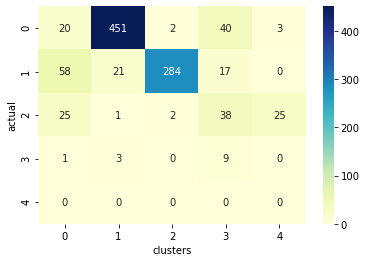

In [100]:
# taking the 1000 first rows of data for K-means algorithm.

sampled_df=norm_data.head(N)
kmeans = KMeans(n_clusters = 5)
kmeans.fit(sampled_df)
labels = kmeans.predict(sampled_df)
centroids = kmeans.cluster_centers_

sampled_df['cluster'] = kmeans.labels_
print('Clusters: ')
print(sampled_df['cluster'].value_counts())

results = confusion_matrix(data['feature 42'].head(N), labels)
s = sns.heatmap(results, cmap="YlGnBu", annot=True, fmt="d")
s.set(xlabel='clusters', ylabel='actual')

# Now for each cluster, sample k/n items while using the given probability.
    

In [102]:
clusters_size = sampled_df['cluster'].value_counts()

clusters = init_list_of_objects(5)

for i in range(N):
    clusters[sampled_df['cluster'][i]].append(i)

initial_means = []

for i in range(5):
    initial_means.append(calculateMean(norm_data.iloc[clusters[i]]))

cluster_sample = init_list_of_objects(5)

for i in range(5):
    j = 0
    while len(cluster_sample[i]) < int(sampling_ratio * len(clusters[i])):
        if (clusters[i][j] not in cluster_sample[i]):
            if simpleRandomSampling(probability(norm_data.iloc[clusters[i][j]], centroids[i])):
                cluster_sample[i].append(clusters[i][j])
        j = j + 1 
        if j == len(clusters[i]):
            j = 0

rank_table = init_list_of_dict(5)

samples_means = []

for i in range(5):
    samples_means.append(calculateMean(norm_data.iloc[cluster_sample[i]]))

for i in range(5):   
    for j in range(len(cluster_sample[i])):
        rank_table[i][cluster_sample[i][j]] = calculateErrorWithoutSample(norm_data.iloc[(cluster_sample[i][:j] + cluster_sample[i][j+1:])],
         samples_means[i])

for i in range(5):
    rank_table[i] = dict(sorted(rank_table[i].items(), key=lambda item: item[1]))

############################################ Code to retrieve dict values ################################################## 

# dict_pairs = rank_table[0].items()
# pairs_iterator = iter(dict_pairs)
# for i in range(len(cluster_sample[0])):
#     first_pair = next(pairs_iterator)
#     print(" pair: ", first_pair)

M = N


while M < len(norm_data):
    pred = kmeans.predict(norm_data.iloc[M: M+1])
    error = calculateErrorWithSample(norm_data.iloc[M: M+1], norm_data.iloc[cluster_sample[pred[0]]], initial_means[pred[0]])
    error_out = calculateErrorWithoutSample(norm_data.iloc[cluster_sample[pred[0]]], initial_means[pred[0]])
    if error < error_out:
        if simpleRandomSampling(probability(norm_data.iloc[M], centroids[pred[0]])):
            cluster_sample[pred[0]].append(M)
            cluster_sample[pred[0]].remove(list(rank_table[pred[0]].keys())[0])
            del rank_table[pred[0]][list(rank_table[pred[0]].keys())[0]]
    M = M + 1
    if M % window_size == 0:
        print(M)
        samples_means = []
        for i in range(5):
            samples_means.append(calculateMean(norm_data.iloc[cluster_sample[i]]))

        for i in range(5):   
            for j in range(len(cluster_sample[i])):
                rank_table[i][cluster_sample[i][j]] = calculateErrorWithoutSample(norm_data.iloc[(cluster_sample[i][:j] + cluster_sample[i][j+1:])],
                samples_means[i])
        
        for i in range(5):
            rank_table[i] = dict(sorted(rank_table[i].items(), key=lambda item: item[1]))    

    

1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000


KeyboardInterrupt: 